In [1]:
%%javascript
//disable scrolling
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Practical Work 8 - Clustering algorithms

## Students
- Flavia Pittet
- Fabio Vitali


### Exercice 1 Getting the data

a) Load the two given datasets :

    `X1,label1 = pickle.load(open("dataset_1.pkl","rb")
    X2,label2 = pickle.load(open("dataset_2.pkl","rb")`


In [2]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
import numpy as np
from numpy import linalg as la
import scipy

In [3]:
def load(filename):
    with open(filename, 'rb') as f:
        X, label = pickle.load(f, encoding='latin1')
        return X, label
X1,label1 = load("data/dataset_1.pkl")
X2,label2 = load("data/dataset_2.pkl")


b) Visualize the data using various color for each unique labels like in figure 1

In [4]:
def plot_data(X, label, title='', pl=None, centroids=None):
    if not pl:
        fig = plt.figure(figsize=(7,7))
        pl = fig.add_subplot(1, 1, 1)
    
    pl.set_title(title)
    label_set = set(label)
    
    mins = []
    maxs = []
    for l in label_set:
        x = [vx[0] for (vx, vl) in zip(X, label) if vl == l]
        y = [vx[1] for (vx, vl) in zip(X, label) if vl == l]
        mins.append([min(x), min(y)])
        maxs.append([max(x), max(y)])
        pl.scatter(x, y, alpha=0.4)
    
    if centroids != None:
        x = [vx[0] for vx in centroids]
        y = [vx[1] for vx in centroids]
        pl.scatter(x, y, marker='x')
        
        for i in range(len(centroids)):
            centroid = centroids[i]
            
            e = Ellipse(centroids[i], maxs[i][0] - mins[i][0], maxs[i][1] - mins[i][1])
            e.set_alpha(0.1)
            pl.add_artist(e)


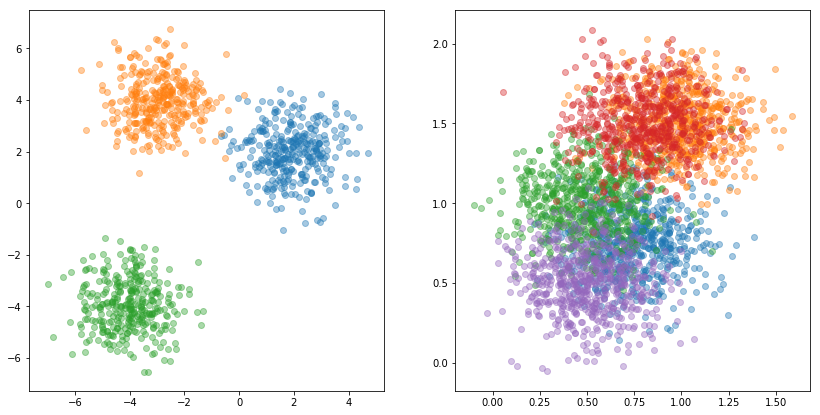

In [5]:
fig = plt.figure(figsize=(14,7))
pl = fig.add_subplot(1, 2, 1)
plot_data(X1, label1, pl=pl)

pl = fig.add_subplot(1, 2, 2)
plot_data(X2, label2, pl=pl)

## Exercice 2 - k-nn algorithm

Using numpy, implements the k-means algorithm as follow :

a) Initialise the centroids µ1, µ2, . . . , µK.

b) Until convergence :

    i) Find the closest centroid for each point
    ii) Reevaluate the centroids
    
c) Return the centroids and the label predicted.

We also ask you to define and implement strategies for the :

- Initialisation of the centroids: 
    we are generating random x and y coordonates with the `init_centroids` function. This way, we can have different values each time the function is called.

- Convergence criteria.


In [6]:
def init_centroids(X, K):
    xmin = min([x[0] for x in X])
    xmax = max([x[0] for x in X])
    ymin = min([x[1] for x in X])
    ymax = max([x[1] for x in X])
    
    return [[x, y] for x, y in zip(
        np.random.uniform(xmin, xmax, K),
        np.random.uniform(ymin, ymax, K)
    )]
centroids = init_centroids(X1, 3)
print(centroids)

[[-3.2369132045757762, -2.2648116101931492], [3.4127768767657987, -2.7009074606670014], [-4.660463816572024, 2.8189250112704114]]


In [18]:
def closest_centroid(centroids, points):
    labels = []
    for p in points:
        labels.append(np.argmin([la.norm(p - c) for c in centroids]))
    return labels

def evaluate_centroids(points, labels):
    labels_set = set(labels)
    
    centroids = []
    for l in labels_set:
        centroids.append(
            [
                np.average([p[0] for (p, vl) in zip(points, labels) if vl == l]),
                np.average([p[1] for (p, vl) in zip(points, labels) if vl == l])
            ]
        )
        
    return centroids

def dist_sum(points1, points2):
    return sum([la.norm(np.array(p1) - np.array(p2)) for p1, p2 in zip(points1, points2)])

def J(X, centroids, labels):
    return sum([la.norm(p - centroids[l]) for p, l in zip(X, labels)])

def K_means(X, K, stop_dist=0.001):
    centroids = init_centroids(X, K)
    
    centroids_history = [centroids]
    labels = closest_centroid(centroids, X)
    costs = [J(X, centroids, labels)]

    labels_history = [labels]
    while True:
        labels = closest_centroid(centroids, X)
        labels_history.append(labels)
        
        evaluation = evaluate_centroids(X, labels)
        centroids_history.append(evaluation)
        
        costs.append(J(X, evaluation, labels))

        if dist_sum(evaluation, centroids) < stop_dist:
            return labels, evaluation, costs, labels_history, centroids_history
        
        centroids = evaluation
        

def process_and_plot(X, K, max_plots=11):
    labels, centroids, costs, labels_history, centroids_history = K_means(X, K)
    datas = np.array(list(zip(labels_history, centroids_history, range(len(costs)))))
    
    if len(datas) > max_plots:
        datas = datas[np.linspace(0, len(datas), max_plots, dtype=np.int32, endpoint=False)]

    fig = plt.figure(figsize=(14, 7 * (len(datas) + 2) / 2))

    i = 0
    for h_label, h_centroids, step in datas:
        pl = fig.add_subplot(np.ceil((len(datas) + 1) / 2), 2, i + 1)
        plot_data(X, h_label, title='Step {}'.format(step), pl=pl, centroids=h_centroids)
        i = i + 1

    pl = fig.add_subplot(np.ceil((len(datas) + 1) / 2), 2, len(datas) + 1)
    pl.set_title('Steps and costs')
    pl.plot(range(len(costs)), costs)

    



## 3. Evaluate your model

At this point, your k-means algorithm is working :

- Visualize your convergence criteria over the epochs 2 using the dataset 1.
- Visualize the output of your k-means on the dataset 1.
- Do you experience sensitivity to the initial values of the centroids ? Is your strategy for initialization working well in most cases ?
    we have have a few cases where the results were completly off, depending on the stoping distance. Here for example, our last step wasn't conclusive with a 0.1 stopping distance.
    ![stopping_dist_01.png](stoppingDist)
- Document your convergence criteria. Could you think about another convergence criteria ?


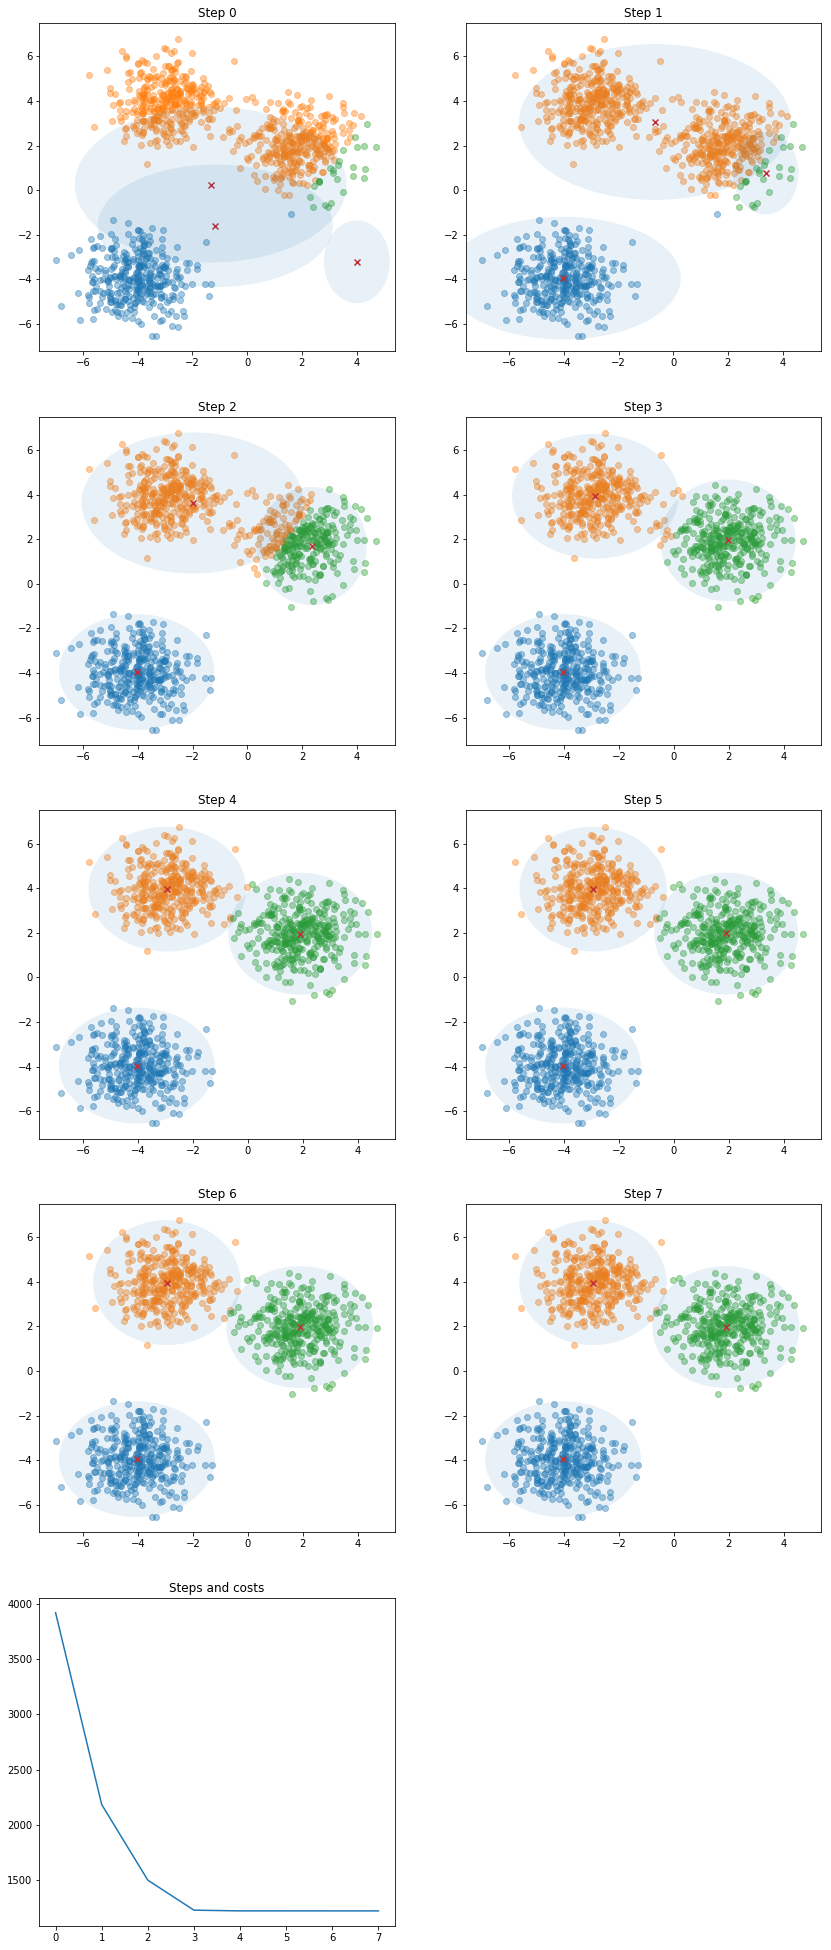

In [19]:
process_and_plot(X1, 3)

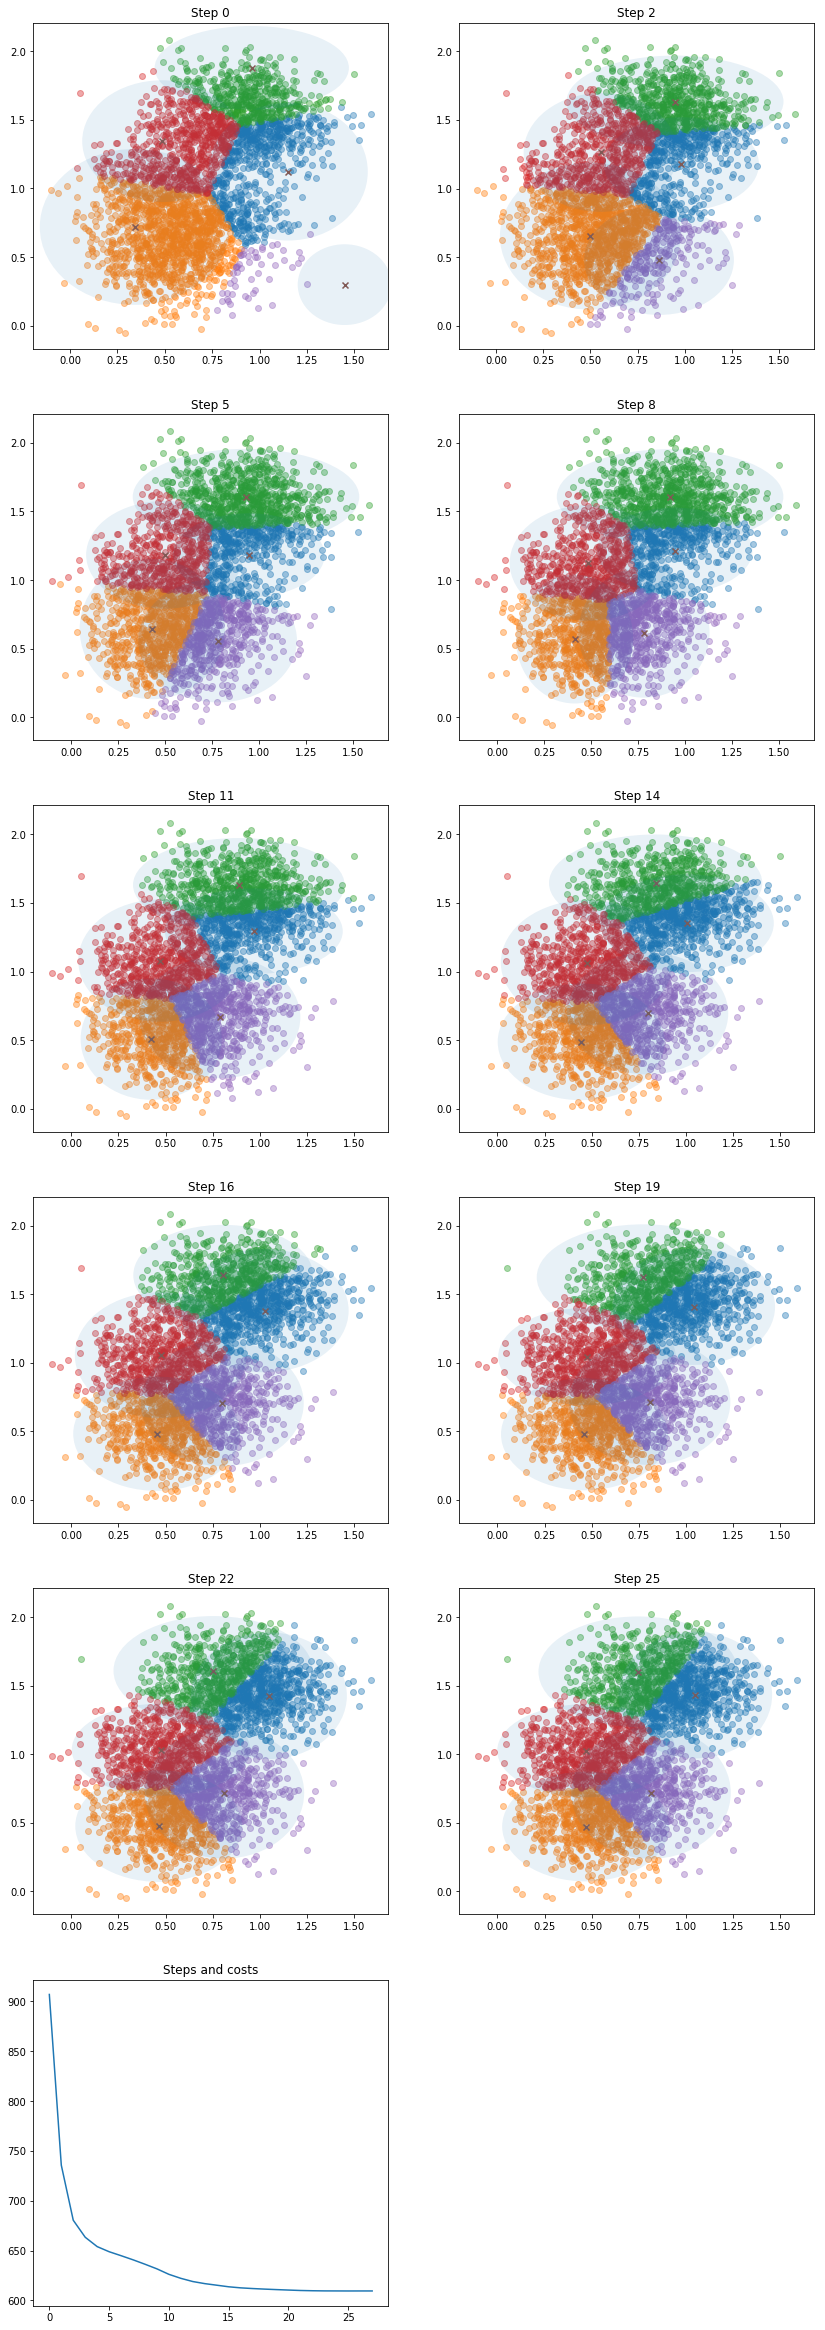

In [8]:
process_and_plot(X2, 5, max_plots=10)